In [1]:
from row_lstm import RowLSTM
from flax import nnx
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import optax
import treescope
import keras
import tqdm
treescope.register_as_default()

2025-07-27 16:31:16.715262: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-27 16:31:16.737845: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-27 16:31:16.743579: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import wandb
wandb.login()

wandb: Currently logged in as: apoorvreddy to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [3]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
assert x_train.shape == (60000, 28, 28)
assert x_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)

In [4]:
def display_image_grid(images, grid_shape):
    assert images.shape[0] == grid_shape[0] * grid_shape[1]
    fig, axes = plt.subplots(grid_shape[0], grid_shape[1], figsize=grid_shape)
    fig.patch.set_facecolor('black') # Set background to black for better contrast
    plt.subplots_adjust(wspace=0.05, hspace=0.05)

    for i, ax in enumerate(axes.flat):
        img_to_show = images[i]
        ax.imshow(img_to_show, cmap='gray')
        ax.axis('off') # Hide the x and y axes
    plt.show()

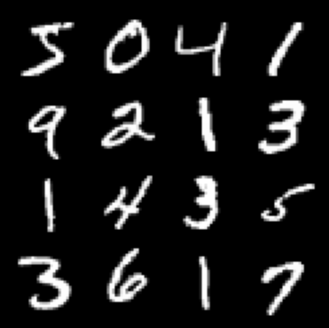

In [5]:
display_image_grid(x_train[:16], (4, 4))

In [6]:
class Batcher:
    def __init__(self, images, batch_size, binarize: bool = False):
        self.images = images
        self.bsz = batch_size
        self.iter = 0
        self.binarize = binarize
    
    def get_batch(self):
        if (self.iter + 1) * self.bsz < self.images.shape[0]:
            start_idx = self.iter * self.bsz
            end_idx = (self.iter + 1) * self.bsz
            self.iter += 1
            batch = (self.images[start_idx: end_idx][..., jnp.newaxis])
            if self.binarize:
                return batch/256.0 > 0.5
            return batch
        else:
            self.shuffle()
            return self.get_batch()
    
    def shuffle(self):
        np.random.shuffle(self.images)
        self.iter = 0

In [7]:
def compute_nll(logits_bmnd, im_bmnc):
    # compute negative log-likelihood of a batch
    logprob_bmnd = nnx.log_softmax(logits_bmnd)
    logprob_bmn = logprob_bmnd[im_bmnc[:,:,:,0]]
    return -jnp.mean(jnp.sum(logprob_bmn, axis=[1, 2]))

def compute_loss(model, image_batch, binarize):
    logits = model(image_batch)
    if binarize:
        labels = image_batch
        loss = optax.sigmoid_binary_cross_entropy(logits, labels)
        loss = jnp.mean(loss)
    else:
        labels = nnx.one_hot(image_batch[:,:,:,0], 256)
        loss = optax.softmax_cross_entropy(logits, labels, axis=-1)
        loss = jnp.mean(loss)
    return loss

def compute_metrics(model, image_batch, binarize):
    logits = model(image_batch)

    if binarize:
        labels = image_batch
        loss = optax.sigmoid_binary_cross_entropy(logits, labels)
        nll = jnp.mean(jnp.sum(loss, axis=[1, 2]))
        loss = jnp.mean(loss)

        top1_accuracy = ((logits > 0).astype(jnp.int8) == image_batch)
        top1_accuracy = jnp.mean(jnp.mean(top1_accuracy, axis=[1, 2]))

    else:
        labels = nnx.one_hot(image_batch[:,:,:,0], 256)
        loss = optax.softmax_cross_entropy(logits, labels, axis=-1)
        loss = jnp.mean(loss)

        top1_accuracy = (jnp.argmax(logits) == image_batch[:,:,:,0])
        top1_accuracy = jnp.mean(jnp.mean(top1_accuracy, axis=[1, 2]))
    
        nll = compute_nll(logits, image_batch, binarize)

    return loss, top1_accuracy, nll


@nnx.jit(static_argnames=['binarize'])
def train_step(model, optimizer, batch, binarize):
    grad_fn = nnx.value_and_grad(compute_loss)
    loss, grads = grad_fn(model, batch, binarize)
    optimizer.update(grads)
    return loss

@nnx.jit(static_argnames=['binarize'])
def eval_step(model, batch, eval_metrics, binarize):
    loss, top1_accuracy, nll = compute_metrics(model, batch, binarize)

    eval_metrics.update(
        loss=loss,
        accuracy=top1_accuracy,
        nll=nll
    )

In [8]:
def count_params(model):
    params = nnx.state(model, nnx.Param)
    total_params  = sum(np.prod(x.shape) for x in jax.tree_util.tree_leaves(params))
    print(total_params)

    for path, x in jax.tree_util.tree_leaves_with_path(params):
        print(path, np.prod(x.shape))
    return total_params

## Overfit on one image

In [9]:
# image = x_train[5].astype(np.uint8)
# batch = (image[jnp.newaxis, ... , jnp.newaxis])

# batcher = Batcher(x_train, 1, binarize=True)
# batch = batcher.get_batch()

# plt.figure(figsize=(1, 1))
# plt.imshow(batch[0], cmap='gray')

# rngs = nnx.Rngs(params=0)

# hidden_dim=16
# is_kernel_length=3
# ss_kernel_length=3
# output_conv_out_channels = [32, 32]
# num_layers = 8
# enable_skip_connections = True
# preds_dim = 1

# model = RowLSTM(hidden_dim=hidden_dim,
#                 is_kernel_length=is_kernel_length,
#                 ss_kernel_length=ss_kernel_length,
#                 num_layers=num_layers,
#                 enable_skip_connections=enable_skip_connections,
#                 output_conv_out_channels=output_conv_out_channels,
#                 preds_dim=1,
#                 rngs=rngs)
# num_params = count_params(model)
# optimizer = nnx.Optimizer(model, optax.rmsprop(
#     learning_rate=1e-2,
# ))


In [10]:
# for i in range(200):
#     loss = train_step(model, optimizer, batch, binarize=True)
#     print(f"loss[{i}]: {loss}")

In [11]:
# gen_image_batch = model.generate(28, 28, 4, jax.random.key(2))
# display_image_grid(gen_image_batch[:,:,:,0], (2, 2))

## Train on entire MNIST dataset.

In [12]:
bar_format = "{desc}[{n_fmt}/{total_fmt}]{postfix} [{elapsed}<{remaining}]"
batch_size = 16
train_total_steps = x_train.shape[0] // batch_size
num_epochs = 60
eval_total_steps = x_test.shape[0] // batch_size
binarize = True


eval_metrics = nnx.MultiMetric(
    loss=nnx.metrics.Average('loss'),
    accuracy=nnx.metrics.Average('accuracy'),
    nll=nnx.metrics.Average('nll')
)

train_metrics_history = {
    "train_loss": [],
}

eval_metrics_history = {
    "test_loss": [],
    "test_accuracy": [],
    "test_nll": []
}

def train_one_epoch(epoch, model, optimizer, binarize):
    model.train()  # Set model to the training mode: e.g. update batch statistics
    with tqdm.tqdm(
        desc=f"[train] epoch: {epoch}/{num_epochs}, ",
        total=train_total_steps,
        bar_format=bar_format,
        leave=True,
    ) as pbar:
        batcher = Batcher(x_train, batch_size, binarize)
        batcher.shuffle()
        for i in range(train_total_steps):
            batch = batcher.get_batch()
            loss = train_step(model, optimizer, batch, binarize)
            train_metrics_history["train_loss"].append(loss.item())
            wandb.log({"train_loss": loss.item(), "samples": epoch * train_total_steps * batch_size + (i+1) * batch_size})
            pbar.set_postfix({"loss": loss.item()})
            pbar.update(1)


def evaluate_model(epoch, model, binarize):
    # Compute the metrics on the train and val sets after each training epoch.
    model.eval()  # Set model to evaluation model: e.g. use stored batch statistics
    with tqdm.tqdm(
        desc=f"[eval] epoch: {epoch}/{num_epochs}, ",
        total=eval_total_steps,
        bar_format=bar_format,
        leave=True,
    ) as pbar:
        eval_metrics.reset()  # Reset the eval metrics
        batcher = Batcher(x_test, batch_size, binarize)
        for i in range(eval_total_steps):
            batch = batcher.get_batch()
            eval_step(model, batch, eval_metrics, binarize)
            pbar.update(1)

        for metric, value in eval_metrics.compute().items():
            wandb.log({f'test_{metric}': value})
            eval_metrics_history[f'test_{metric}'].append(value)

    print(f"[eval] epoch: {epoch}/{num_epochs}")
    print(f"- total loss: {eval_metrics_history['test_loss'][-1]:0.4f}")
    print(f"- Accuracy: {eval_metrics_history['test_accuracy'][-1]:0.4f}")
    print(f"- NLL: {eval_metrics_history['test_nll'][-1]:0.4f}")

In [13]:
#@title Training Config

# data

rngs = nnx.Rngs(params=0)
# model
hidden_dim=32
is_kernel_length=3
ss_kernel_length=3
output_conv_out_channels = [32, 32]
num_layers = 8
enable_skip_connections = True
preds_dim = 1 if binarize else 256

#lr_scheduler
lr_init_value=1e-7
lr_peak_value=1e-4
lr_warmup_steps=200
lr_decay_steps=125000

run = wandb.init(
    project="pixel-rnn-mnist",  # Specify your project
    config={                        # Track hyperparameters and metadata
        "lr_scheduler": {
            'init_value': lr_init_value,
            'peak_value': lr_peak_value,
            'warmup_steps': lr_warmup_steps,
            'decay_steps': lr_decay_steps
        },
        "model": {
            "hidden_dim": hidden_dim,
            "input_conv_kernel": (7, 7),
            "is_kernel_length": is_kernel_length,
            "ss_kernel_length": ss_kernel_length,
            "output_conv_channels": output_conv_out_channels,
            "residual_connections": True,
            "num_layers": num_layers,
            "learned_hidden_init": True,
            "enable_skip_connections": enable_skip_connections,
            "preds_dim": preds_dim
        },
        "training": {
            "batch_size": batch_size,
            "epochs": num_epochs,
            "binarize": binarize
        },
        "architecture": "row-lstm"
    },
)

wandb.define_metric("train_loss", step_metric="samples")
wandb.define_metric("test_nll", step_metric="samples")
wandb.define_metric("test_accuracy", step_metric="samples")
wandb.define_metric("test_loss", step_metric="samples")

In [14]:
model = RowLSTM(hidden_dim=hidden_dim,
                is_kernel_length=is_kernel_length,
                ss_kernel_length=ss_kernel_length,
                output_conv_out_channels=output_conv_out_channels,
                num_layers=num_layers,
                enable_skip_connections=enable_skip_connections,
                preds_dim=preds_dim,
                rngs=rngs)
lr_scheduler = optax.warmup_cosine_decay_schedule(
    init_value=lr_init_value,
    peak_value=lr_peak_value,
    warmup_steps=lr_warmup_steps,
    decay_steps=lr_decay_steps
)
optimizer = nnx.Optimizer(model, optax.rmsprop(lr_scheduler))

In [ ]:
for epoch in range(num_epochs):
    train_one_epoch(epoch, model, optimizer, binarize)
    evaluate_model(epoch, model, binarize)

[train] epoch: 0/60, [3750/3750], loss=0.0891 [03:04<00:00]
[eval] epoch: 0/60, [0/625] [00:00<?]

In [ ]:
gen_image_batch = model.generate(28, 28, 100, jax.random.key(123))
display_image_grid(gen_image_batch, (10, 10))